<a href="https://colab.research.google.com/github/Nikhileswar-Komati/Suicide_Ideation/blob/master/BERT_Suicide_Ideation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import re
from collections import defaultdict
np.seterr(divide = 'ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [ ]:
from google.colab import files
files.upload()

In [4]:
data = pd.read_csv('/content/500_Reddit_users_posts_labels.csv', index_col = 'User')
data.head(5)

,Post,Label
User,,
user-0,"['Its not a viable option, and youll be leavin...",Supportive
user-1,['It can be hard to appreciate the notion that...,Ideation
user-2,"['Hi, so last night i was sitting on the ledge...",Behavior
user-3,['I tried to kill my self once and failed badl...,Attempt
user-4,['Hi NEM3030. What sorts of things do you enjo...,Ideation


In [5]:
data.shape

(500, 2)

In [6]:
data['Label'].value_counts()

Ideation      171
Supportive    108
Indicator      99
Behavior       77
Attempt        45
Name: Label, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


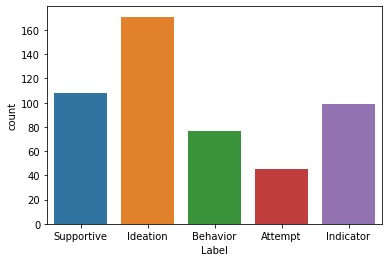

In [7]:
import seaborn as sns
sns.countplot(data['Label'])

In [8]:
data['Post'][0]

"['Its not a viable option, and youll be leaving your wife behind. Youd Pain her beyond comprehension.It sucks worrying about money, I know that first hand. It can definitely feel hopeless, as you seem to be Tired aware of. Your wife might need to chip in financially. I know time is an issue, but even 10-15 hours a Asthenia could alleviate a lot of the pressure. In the meantime, get your shit together - write that resume tomorrow. No excuses, get it done and send it out. Whether you believe in some sort of powerful being or force governing things or not, things really do work themselves out. This is a big test for you, and youll pull through. Just try to stay as positive as you can and everything will work out.']"

In [9]:
text = "Hello, Stupid:: idiot!"
def preprocess(string):
  processed_string = re.sub('[^a-z0-9]+', ' ', string, flags=re.IGNORECASE)
  processed_string = re.sub('(\s+)', ' ', processed_string)
  processed_string = processed_string.lower()
  return processed_string
print(preprocess(data['Post'][0]))

 its not a viable option and youll be leaving your wife behind youd pain her beyond comprehension it sucks worrying about money i know that first hand it can definitely feel hopeless as you seem to be tired aware of your wife might need to chip in financially i know time is an issue but even 10 15 hours a asthenia could alleviate a lot of the pressure in the meantime get your shit together write that resume tomorrow no excuses get it done and send it out whether you believe in some sort of powerful being or force governing things or not things really do work themselves out this is a big test for you and youll pull through just try to stay as positive as you can and everything will work out 


In [10]:
X = data['Post'].values
y = data['Label'].values

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y = le.fit_transform(y)
# X = list(X)
# y = list(y)
print(set(y))
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.04, random_state = 42)
print(len(train_X), len(test_X))

{0, 1, 2, 3, 4}
480 20


In [11]:
cleaned_train_data = [preprocess(ele) for ele in train_X]
cleaned_test_data = [preprocess(ele) for ele in test_X]


In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import logging
logging.basicConfig(level=logging.INFO)

In [13]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [14]:
pip install sentencepiece

     |████████████████████████████████| 1.1MB 7.4MB/s 


In [15]:
import tensorflow_hub as hub
import tokenization
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

INFO:absl:resolver HttpCompressedFileResolver does not support the provided handle.
INFO:absl:resolver GcsCompressedFileResolver does not support the provided handle.


In [16]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [92]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    out = tf.keras.layers.Dense(5, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [93]:
import keras
max_len = 512
train_input = bert_encode(cleaned_train_data, tokenizer, max_len = max_len)
test_input = bert_encode(cleaned_test_data, tokenizer, max_len = max_len)
train_labels = keras.utils.to_categorical(train_y, num_classes = 5)

In [94]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "functional_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 512)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        multiple             109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]     

In [95]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_history = model.fit(
    train_input, train_labels, 
    validation_split = 0.05,
    epochs = 10,
    callbacks = [checkpoint, earlystopping],
    batch_size = 8,
    verbose = 1)

Epoch 1/10
57/57 [==============================] - ETA: 0s - loss: 0.7282 - accuracy: 0.7654WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0106s vs `on_test_batch_end` time: 0.1736s). Check your callbacks.



Epoch 00001: val_accuracy improved from -inf to 0.29167, saving model to model.h5
57/57 [==============================] - 38s 662ms/step - loss: 0.7282 - accuracy: 0.7654 - val_loss: 1.9315 - val_accuracy: 0.2917
Epoch 2/10
57/57 [==============================] - ETA: 0s - loss: 0.3576 - accuracy: 0.9189
Epoch 00002: val_accuracy improved from 0.29167 to 0.33333, saving model to model.h5
57/57 [==============================] - 37s 651ms/step - loss: 0.3576 - accuracy: 0.9189 - val_loss: 2.5479 - val_accuracy: 0.3333
Epoch 3/10
57/57 [==============================] - ETA: 0s - loss: 0.2470 - accuracy: 0.9254
Epoch 00003: val_accuracy improved from 0.33333 to 0.37500, saving model to model.h5
57/57 [==============================] - 37s 650ms/step - loss: 0.2470 - accuracy: 0.9254 - val_loss: 2.9060 - val_accuracy: 0.3750
Epoch 4/10
57/57 [==============================] - ETA: 0s - loss: 0.1711 - accuracy: 0.9496
Epoch 00004: val_accuracy did not improve from 0.37500
57/57 [=======

In [ ]:
model.load_weights('model.h5')
test_pred = model.predict(test_input)

In [30]:
train_labels.shape

(480, 5)

In [24]:
test_pred

array([[0.09998046, 0.1805445 , 0.2520294 , 0.17918935, 0.28825626],
       [0.10101527, 0.16570438, 0.22587045, 0.1606261 , 0.34678385],
       [0.11741017, 0.15628521, 0.28891724, 0.20571911, 0.23166823],
       [0.13208771, 0.17883368, 0.2823318 , 0.19723485, 0.20951195],
       [0.12021708, 0.17642146, 0.2722318 , 0.18669635, 0.24443333],
       [0.1388501 , 0.16471231, 0.2803631 , 0.19566241, 0.22041206],
       [0.1001479 , 0.16096562, 0.2761348 , 0.2010278 , 0.26172388],
       [0.10448053, 0.13518941, 0.27701324, 0.2221004 , 0.2612164 ],
       [0.13348621, 0.16104063, 0.29138276, 0.19310567, 0.22098467],
       [0.13724664, 0.16818418, 0.3102739 , 0.19411135, 0.19018394],
       [0.11226063, 0.18066926, 0.30572274, 0.18603393, 0.21531339],
       [0.10644772, 0.152344  , 0.27462938, 0.17862922, 0.28794968],
       [0.12546329, 0.19720966, 0.28102323, 0.17912908, 0.21717475],
       [0.11952727, 0.18626414, 0.26675895, 0.16571304, 0.2617366 ],
       [0.11227054, 0.17409152, 0.